In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F          
from torch.utils.data import DataLoader  
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix  # for evaluating results
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

Extracting ../Data/MNIST/raw/train-images-idx3-ubyte.gz to ../Data/MNIST/raw


Extracting ../Data/MNIST/raw/train-labels-idx1-ubyte.gz to ../Data/MNIST/raw


Extracting ../Data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../Data/MNIST/raw


Extracting ../Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../Data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
print(train_data,'\n',test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor() 
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()


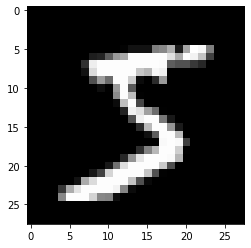

In [6]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gray");

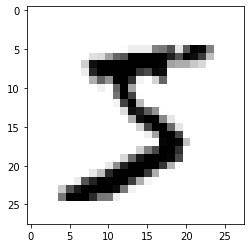

In [7]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gist_yarg");

In [8]:
torch.manual_seed(101)  # for consistent results

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

Labels:  [   0    5    7    8    6    7    9    7    1    3    8    4]


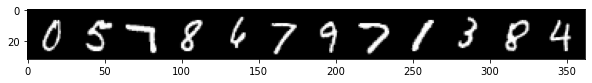

In [9]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array
for images,labels in train_loader: 
    break
print('Labels: ', labels[:12].numpy())
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [10]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [11]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Load the first batch, print its shape
for images, labels in train_loader:
    print('Batch shape:', images.size())
    break

Batch shape: torch.Size([100, 1, 28, 28])


In [16]:
images.view(100,-1).size()

torch.Size([100, 784])

In [17]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train.view(100, -1))  # Here we flatten X_train
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(500, -1))  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  200 [ 20000/60000]  loss: 0.35145184  accuracy:  82.675%
epoch:  0  batch:  400 [ 40000/60000]  loss: 0.32269010  accuracy:  87.368%
epoch:  0  batch:  600 [ 60000/60000]  loss: 0.31343848  accuracy:  89.523%
epoch:  1  batch:  200 [ 20000/60000]  loss: 0.20294856  accuracy:  94.755%
epoch:  1  batch:  400 [ 40000/60000]  loss: 0.14465864  accuracy:  95.155%
epoch:  1  batch:  600 [ 60000/60000]  loss: 0.12704472  accuracy:  95.448%
epoch:  2  batch:  200 [ 20000/60000]  loss: 0.13923304  accuracy:  96.825%
epoch:  2  batch:  400 [ 40000/60000]  loss: 0.07193176  accuracy:  96.728%
epoch:  2  batch:  600 [ 60000/60000]  loss: 0.03873893  accuracy:  96.843%
epoch:  3  batch:  200 [ 20000/60000]  loss: 0.09367509  accuracy:  97.605%
epoch:  3  batch:  400 [ 40000/60000]  loss: 0.07943495  accuracy:  97.562%
epoch:  3  batch:  600 [ 60000/60000]  loss: 0.08546878  accuracy:  97.530%
epoch:  4  batch:  200 [ 20000/60000]  loss: 0.05990553  accuracy:  98.175%
epoch:  4  b

In [21]:

test_load_all = DataLoader(test_data, batch_size=10000, shuffle=True)

In [24]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):5f}%')

Test accuracy: 9723/10000 = 97.230000%


In [25]:

np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 969    0    4    0    1    1    6    0    3    1]
 [   0 1128    5    0    0    0    3    7    0    4]
 [   2    1 1000    4    6    0    2    8    1    0]
 [   1    0    6  981    0    3    1    4    3    7]
 [   0    0    1    0  962    1    1    0    3   11]
 [   3    1    1   18    0  884   33    1   19   16]
 [   0    2    2    0    3    1  909    0    1    0]
 [   2    0    4    4    3    1    1 1002    4   11]
 [   2    3    9    2    1    1    2    2  937    8]
 [   1    0    0    1    6    0    0    4    3  951]]
